# <center> Финальное здание.
#### <center> Разведывательный анализ данных. EDA-5. A/B-тестирование

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. В результате проведения эксперимента собраны данные.

Задача: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведённого анализа необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Фирма предлагает следующие варианты туров и их соответствующие стоимости:

Таиланд — 100 000 рублей;
Турция — 60 000 рублей;
Мальдивы — 200 000 рублей;
Санкт-Петербург — 10 000 рублей;
Камчатка — 150 000 рублей.


In [1]:
import pandas as pd
data = pd.read_csv('../Data x analysis/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


* user_id - идентификатор пользователя, зашедшего на сайт
* date - дата захода
* group - группа теста (контрольная — А или тестовая — B)
* purchase - признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет)
* price - цена купленного тура (если покупка не состоялась, цена равна 0)

*** 

Задание 7.1

Начнём с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Задание 7.2

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из групп. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп.

В какой промежуток времени проводился A/B-тест?

In [3]:
data['date'] = pd.to_datetime(data['date'])
print(data['date'].dt.date.min(), data['date'].dt.date.max()) 

2021-01-02 2021-01-24


Задание 7.3

Чему равно количество посещений сайта в группах А и B?

In [4]:
data.groupby('group')['user_id'].count()

group
A    147202
B    147276
Name: user_id, dtype: int64

Чему равно суммарное количество покупок в группах А и B?

In [5]:
data.groupby('group')['purchase'].sum()

group
A    17723
B    17514
Name: purchase, dtype: int64

Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [6]:
data['revenue'] = data['purchase'] * data['price']
data.groupby('group')['revenue'].sum().apply(lambda x: round(x/1e6, 2))


group
A    1436.26
B    1554.10
Name: revenue, dtype: float64

Задание 7.4

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет, введите в поле для ответа 0.

In [7]:
intersection_users = pd.merge(data[data['group'] == 'A'], 
                              data[data['group'] == 'B'], 
                              how='inner', 
                              on=['user_id']                             
                              )
display(len(intersection_users))

1895

Исключаем пользователей, оказавшихся в обеих группах.

In [8]:
user_intersection_set = set(intersection_users['user_id'])
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection_set)]

Задание 7.5

Для первичного анализа результатов A/B-тестирования нам понадобится получить таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:

* количество посещений (количество пользователей);
* количество совершённых покупок;
* сумма всех покупок в группе.

В полученной сгруппированной таблице переименуйте столбцы на count_visits, count_purchases и sum_price.

Чему на этот раз равно количество посещений сайта в группах А и B?

In [9]:
group_data = updated_data.groupby('group').agg(
    count_visits=pd.NamedAgg(column='user_id', aggfunc='count'),
    count_purchases=pd.NamedAgg(column='purchase', aggfunc='sum'),
    sum_price=pd.NamedAgg(column='price', aggfunc='sum')).reset_index()

display(group_data)

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


✍️ Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?



>Вывод: После исключения пользователей, оказавшихся в обеих группах, наблюдаем достаточно сбалансированную выборку с минимальной разницей по количеству пользователей посетивших два варианта посадочной страницы.

Задание 7.6

Добавьте в сгруппированную таблицу столбцы conversion — конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check — средний чек (отношение суммы покупок к количеству покупок в каждой группе).

Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12.

In [10]:
group_data['conversion'] = group_data['count_purchases'] / group_data['count_visits'] * 100
group_data['mean_check'] = group_data['sum_price'] / group_data['count_purchases']

group_data = group_data.round(2)
display(group_data)

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.23
1,B,145381,17290,1533010000,11.89,88664.55


✍️ Приведите промежуточные выводы по таблице. По какому(-им) показателю(-ям) вариант А эффективнее варианта B и наоборот?

>Вывод: При анализе данных в расчете конверсии и среднего чека можно увидеть противоположную закономерность, что в варианте посадочной страницы А - количество покупок и конверсия выше. В то же время, вариант В показал более высокий средний чек и сумму покупок тура.

Задание 7.7

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура.

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией.

Чему равно количество проданных туров за 60 000 рублей в группах?

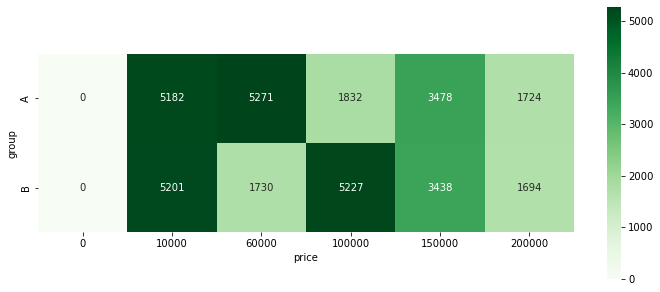

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = updated_data.pivot_table(
    values='purchase',
    index='group',
    columns='price',
    aggfunc='sum'
)

fig = plt.figure(figsize=(12, 5))
sns.heatmap(pivot, 
            annot=True, 
            fmt="d",
            cmap="Greens",
            square=True);

✍️ Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B, и наоборот?

>Вывод: При рассмотрении тепловой карты можно смело сделать вывод, что покупательская способность участников в группе А весьма выше по турам за 60 000 рублей. А в группе В - за 100 000 рублей, что явно подтверждает предыдущий вывод и разница в среднем чеке покупки. По остальным ценовым категориям туров разница несущественна. 

Задание 7.8

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде чем перейти к кумулятивным метрикам, необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок.

In [12]:
date_data = updated_data.groupby(['date', 'group']).agg(
    count_visits=pd.NamedAgg(column='user_id', aggfunc='count'),
    count_purchases=pd.NamedAgg(column='purchase', aggfunc='sum'),
    sum_price=pd.NamedAgg(column='price', aggfunc='sum')).reset_index()

display(date_data.head())

,date,group,count_visits,count_purchases,sum_price
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,6596,748,62000000
3,2021-01-03,B,6619,754,65960000
4,2021-01-04,A,6566,799,64250000


Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок).

In [13]:
date_data['conversion'] = date_data['count_purchases'] / date_data['count_visits'] * 100
date_data['mean_check'] = date_data['sum_price'] / date_data['count_purchases']

display(date_data.head())

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых

In [14]:
date_data[date_data['date'] == '2021-01-03'].loc[:, ['group', 'conversion']].round(2)

,group,conversion
2,A,11.34
3,B,11.39


Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.


In [15]:
date_data[date_data['date'] == '2021-01-03'].loc[:, ['group', 'mean_check']].round()

,group,mean_check
2,A,82888.0
3,B,87480.0


Задание 7.9

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:

* кумулятивное количество посещений страницы;
* кумулятивное количество покупок;
* кумулятивную сумму покупок.

Не забудьте при расчёте кумулятивной суммы сгруппировать данные по группам.


In [16]:
date_data['cum_count_visits'] = date_data.groupby(['group'])['count_visits'].cumsum()
date_data['cum_count_purchases'] = date_data.groupby(['group'])['count_purchases'].cumsum()
date_data['cum_sum_price'] = date_data.groupby(['group'])['sum_price'].cumsum()

date_data.head()

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000



Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей.


In [17]:
date_data['cum_conversion'] = date_data['cum_count_purchases']/date_data['cum_count_visits'] * 100
date_data['cum_mean_check'] = date_data['cum_sum_price']/date_data['cum_count_purchases']
date_data.head()

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530



Какая кумулятивная конверсия была в группе B на 20 января 2021 года? Ответ приведите в процентах, округлив до сотых.


In [18]:
date_data[date_data['date'] == '2021-01-20'].loc[:, ['group', 'cum_conversion']].round(2)

,group,cum_conversion
36,A,11.98
37,B,11.90



Какой кумулятивный средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.


In [19]:
date_data[date_data['date'] == '2021-01-12'].loc[:, ['group', 'cum_mean_check']].round(0)

,group,cum_mean_check
20,A,81492.0
21,B,88352.0



 
✍️ Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершённым — стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

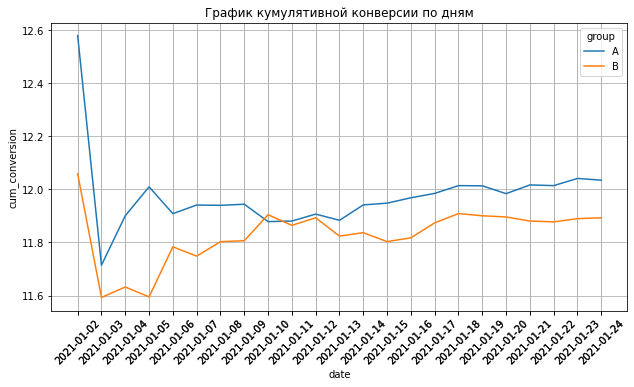

In [40]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=date_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.set_xticks(date_data['date'])
ax.grid(True);

>Вывод: Начиная с 10-го января 2021 года группы имеют похожую тенденцию роста и спада уровня конверсии. До этого периода показатель вел себя противоположно. В группе А конверсия посещений в покупку постоянно выше кроме 9-го января 2021 года. Данные стабилизированы.

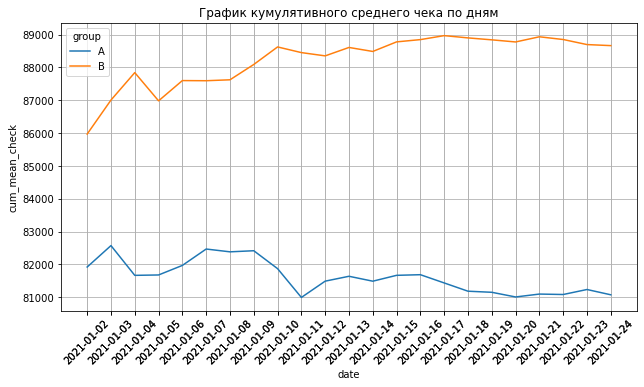

In [41]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=date_data, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.set_xticks(date_data['date'])
ax.grid(True);

>Вывод: За весь период сбора данных у пользователей посетивших вариант посадочной страницы В средний чек стабильно выше, чем у группы А. Данные стабилизированы.

Задание 7.10

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнём с конверсии.
Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?


>Выполним тесты на нормальность распределения по методу Д'Агостино так, как число наблюдений больше 20.

In [22]:
from scipy.stats import normaltest

_, p_a = normaltest(date_data[date_data['group'] == 'A']['conversion'])
_, p_b = normaltest(date_data[date_data['group'] == 'B']['conversion'])
print('p для группы А =%.3f\np для группы B =%.3f' % (p_a, p_b))

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

if p_a < alpha/2 or p_b < alpha/2:
	print(Ha)
else:
	print(H0)

p для группы А =0.629
p для группы B =0.907
Данные распределены нормально


>Данные конверсии распределенные нормально, переменная количественная, поэтому выберем параметрический тест на сравнение выборки двух групп, а именно Z-тест. Конверсия является долевым показателем. Для проверки гипотезы о равенстве долей (пропорций) используется Z-тест для пропорций.


Проведите тестирование при следующих нулевой и альтернативной гипотезе:

* H0: Конверсии в группах А и B равны;
* Ha: Конверсия в группе А больше, чем конверсия в группе B.

Вычислите p value вашего теста для конверсий в группах А и B. Сравните полученное значение с уровнем значимости alpha = 0.05.


In [23]:
data_piv= date_data.groupby('group').agg({
    'count_visits':'sum',
    'count_purchases':'sum'
}).reset_index()
display(data_piv)

,group,count_visits,count_purchases
0,A,145307,17487
1,B,145381,17290


In [24]:
from statsmodels.stats.proportion import proportions_ztest


H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 

_, p_value = proportions_ztest(
    count=data_piv['count_purchases'], 
    nobs=data_piv['count_visits'], 
    alternative='larger'
)

print('p-value: ', round(p_value, 2))

if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. Альтернативная гипотеза. H1: {}. p < alpha".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}. p > alpha".format(H0))


p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны. p > alpha



✍️ Приведите свои выводы по результатам проведённого статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

>Вывод: Осуществив проверку статистической значимости разницы между метриками конверсии в обеих группах мы подтвердили нулевую гипотезу, что конверсии в группах А и Б равны. Разница в истинных значения в группах не значима.

Задание 7.11

Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте Z крит в своих расчётах.

Укажите нижнюю и верхнюю границы доверительных интервалов. Все границы приведите в процентах и округлите до второго знака после запятой. 

Доверительный интервал для конверсии в группах:

In [25]:
from scipy.stats import norm

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 
    lower_bound = x_p - eps 
    upper_bound = x_p + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
    n=updated_data[updated_data['group'] == 'A']['purchase'].count(), 
    x_p=updated_data[updated_data['group'] == 'A']['purchase'].mean()
)
                                                                                                                        
conf_interval_b = proportions_conf_interval(
    n=updated_data[updated_data['group'] == 'B']['purchase'].count(), 
    x_p=updated_data[updated_data['group'] == 'B']['purchase'].mean()
)

print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


Доверительный интервал для разницы конверсии в группах:

In [26]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma
    diff = xp[1] - xp[0]
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 
    lower_bound = diff - eps 
    upper_bound = diff + eps 
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']

n = [a_data['purchase'].count(), b_data['purchase'].count()]
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]

diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
 


Доверительный интервал для разности конверсий: (-0.38, 0.09)



✍️ Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

>Вывод: 
Можно сделать вывод, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.87% до 12.2%, а конверсия группы B лежит в интервале от 11.73% до 12.06%.
Построенный доверительный интервал разницы пропорций с 95%-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38% до 0.09%. 

Задание 7.12

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.
Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования.
Какой тест вы примените для проверки гипотезы о нормальности распределения ежедневного среднего чека?

In [27]:
from scipy.stats import shapiro

H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05

shapiro_result_a = shapiro(date_data[date_data['group'] == 'A']['mean_check'])
shapiro_result_b = shapiro(date_data[date_data['group'] == 'B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Задание 7.13

Настало время сравнить варианты дизайна страницы по метрике среднего чека.

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

In [28]:
from scipy.stats import ttest_ind

H0 = 'Средний ежедневный чек в группах А и B равны'
H1 = 'Средний ежедневный чек в группе А меньше, чем в группе B'

alpha = 0.05

    
results = ttest_ind(
    a=date_data[date_data['group'] == 'A']['mean_check'],
    b=date_data[date_data['group'] == 'B']['mean_check'], 
    alternative='less'

)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value: 0.0
Отвергаем нулевую гипотезу. Альтернативная гипотеза. H1: Средний ежедневный чек в группе А меньше, чем в группе B


✍️ Приведите свои выводы по результатам проведённого статистического теста. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

>Вывод:
По результатам статистического теста мы подтвердили альтернативную гипотезу и предыдущие выводы, что ежедневный средний чек в группе А меньше, чем в группе B. И эта разница имеет статистическую значимость для нашего исследования.

Задание 7.14

Постройте 95 %-ый доверительный интервал для среднего чека в каждой группе. Так как выборка ежедневных средних чеков небольшая, используйте T крит в своих расчётах.

Укажите нижнюю и верхнюю границы доверительного интервала для истинного среднего чека каждой из групп. Ответ округлите до целого.

In [29]:
from scipy.stats import t

def conf_interval(n, x_std, x_mean, gamma=0.95):   
    alpha = 1 - gamma 
    k = n - 1
    t_crit = -t.ppf(alpha/2, k) 
    eps = t_crit * x_std/(n ** 0.5) 
    lower_bound = x_mean - eps 
    upper_bound = x_mean + eps 
    return round(lower_bound), round(upper_bound)

conf_interval_a = conf_interval(
    n=date_data[date_data['group'] == 'A']['mean_check'].count(), 
    x_mean=date_data[date_data['group'] == 'A']['mean_check'].mean(),
    x_std=date_data[date_data['group'] == 'A']['mean_check'].std()
)
                                                                                                                        
conf_interval_b = conf_interval(
    n=date_data[date_data['group'] == 'B']['mean_check'].count(), 
    x_mean=date_data[date_data['group'] == 'B']['mean_check'].mean(),
    x_std=date_data[date_data['group'] == 'B']['mean_check'].std()
)

print('Доверительный интервал для среднего чека группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для среднего чека группы B: {}'.format(conf_interval_b))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


✍️ Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения? О чём это говорит?

>Вывод:
Доверительные интервалы в группах имеют существенную разницу, не пересекаются и соответствуют гипотезе, что средний чек группы В больше, чем в группе А. Доверительный интервал для среднего чека группы B выше по метрике, но является более узким, чем группы А. 

⭐️ Сделайте общий вывод по результатам A/B-теста. Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

>
>После исследованная структуры данных было проведено преобразование даты. При выполнении тестирования мы исключили влияние пользователей посетивших оба варианта, для данного исследования били использовано достаточное количество данных и использованы все современные инструменты для анализа. Была проведена визуальная оценка и сделаны первичные выводы. После расчета кумулятивных метрик и уверенности их стабилизации были проведены статистические тесты и определены доверительные интервалы. 
>
>По результатам A/B-теста более эффективным вариантом дизайна посадочной страницы является группа В. Это вывод был сделан в комплексе метрик, но по оценке среднего чека так, как разница в показателе конверсии не имеет статистической значимости в данном случае. Это было заметно на начальной стадии визуального анализа по сумме покупок тура. Так же присутствует существительная разница в показателях для различных ценовых категорий по турам, что нужно учитывать при выборе дизайна посадочной страницы.